In [1]:
import os, inspect, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

CURRENT_DIR = os.path.dirname(inspect.getabsfile(inspect.currentframe()))
ROOT_DIR = os.path.dirname(CURRENT_DIR)
sys.path.insert(0, ROOT_DIR)

from reb.src.pyts import series_to_supervised

Using TensorFlow backend.


In [2]:
ffname = os.path.join(ROOT_DIR, "reb", "data", "ext", "data_monthly_processed.csv")

In [3]:
df = pd.read_csv(ffname, parse_dates=["DATE"])
df.DATE = pd.to_datetime(df.DATE, format="%Y-%m")
df.head()


,DATE,PAYEMS,USPRIV,AWHNONAG,CES9091000001,USGOVT,UNEMPLOY,LNS13023622,LNS13023706,LNS13023654,LNS13026511,MVPHGFD027MNFRBDAL,MORTGAGE30US,MORTGAGE15US,DGS10,INDPRO,W875RX1
0,1992-01-01,108374,89686,34.1,3137,18688,9283,54.0,11.9,13.1,40.9,2719.3,8.4,8.0,7.0,63.3372,6840.9
1,1992-02-01,108317,89628,34.1,3121,18689,9454,57.0,9.8,13.6,43.3,2738.8,8.8,8.4,7.3,63.7864,6879.1
2,1992-03-01,108369,89654,34.1,3121,18715,9460,57.4,9.5,13.4,44.0,2760.5,8.9,8.6,7.5,64.3199,6884.7
3,1992-04-01,108526,89787,34.3,3117,18739,9415,57.3,10.4,13.6,43.8,2764.0,8.9,8.5,7.5,64.8069,6903.6
4,1992-05-01,108653,89900,34.3,3119,18753,9744,57.7,10.3,12.8,44.9,2830.7,8.7,8.3,7.4,65.0202,6941.7


Make a clen copy of data. This allows us to modify freely while we have always the original data for any further reference.

In [4]:
df_original = df.copy() 

Reindex data frame per the time stamps

In [5]:
df.set_index("DATE", inplace=True)
df.head()

,PAYEMS,USPRIV,AWHNONAG,CES9091000001,USGOVT,UNEMPLOY,LNS13023622,LNS13023706,LNS13023654,LNS13026511,MVPHGFD027MNFRBDAL,MORTGAGE30US,MORTGAGE15US,DGS10,INDPRO,W875RX1
DATE,,,,,,,,,,,,,,,,
1992-01-01,108374,89686,34.1,3137,18688,9283,54.0,11.9,13.1,40.9,2719.3,8.4,8.0,7.0,63.3372,6840.9
1992-02-01,108317,89628,34.1,3121,18689,9454,57.0,9.8,13.6,43.3,2738.8,8.8,8.4,7.3,63.7864,6879.1
1992-03-01,108369,89654,34.1,3121,18715,9460,57.4,9.5,13.4,44.0,2760.5,8.9,8.6,7.5,64.3199,6884.7
1992-04-01,108526,89787,34.3,3117,18739,9415,57.3,10.4,13.6,43.8,2764.0,8.9,8.5,7.5,64.8069,6903.6
1992-05-01,108653,89900,34.3,3119,18753,9744,57.7,10.3,12.8,44.9,2830.7,8.7,8.3,7.4,65.0202,6941.7


In [6]:
# rescale data
values = df.values
values = values.astype("float32")
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values)
n_variables = values.shape[1]

In [7]:
index_target = 15
# set model parameters
n_lags = 6
n_sequences = 6
n_train = int(values_scaled.shape[0] * 0.8)
n_units = 30

In [25]:
# set train parameters
optimizer = "adam"
loss = "mse"
n_epochs = 5
sz_batch = 5
verbose = 1
values_scaled.shape

(320, 16)

In [26]:
df_reframed = series_to_supervised(values_scaled, n_lags, n_sequences)
df_reframed.head()
# [print(elem) for elem in df_reframed.columns]

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),...,var7(t+5),var8(t+5),var9(t+5),var10(t+5),var11(t+5),var12(t+5),var13(t+5),var14(t+5),var15(t+5),var16(t+5)
6,0.001391,0.001554,0.6875,0.596821,0.000000,0.385169,0.510822,0.659794,0.532609,0.530686,...,0.515151,0.536083,0.456522,0.555957,0.025420,0.830508,0.819672,0.815385,0.065500,0.058172
7,0.000000,0.000000,0.6875,0.573699,0.000232,0.402492,0.640693,0.443299,0.586957,0.617328,...,0.493506,0.505155,0.304348,0.595668,0.028109,0.796610,0.786885,0.784615,0.071898,0.020870
8,0.001269,0.000697,0.6875,0.573699,0.006267,0.403100,0.658009,0.412371,0.565217,0.642599,...,0.458874,0.577320,0.369565,0.541516,0.033719,0.745763,0.737705,0.738462,0.078384,0.026726
9,0.005102,0.004261,0.8125,0.567919,0.011838,0.398541,0.653679,0.505155,0.586957,0.635379,...,0.558442,0.597938,0.456522,0.592058,0.036165,0.711864,0.704918,0.692308,0.076377,0.022677
10,0.008203,0.007290,0.8125,0.570809,0.015088,0.431871,0.670996,0.494845,0.500000,0.675090,...,0.554113,0.546392,0.413043,0.606498,0.036940,0.711864,0.704918,0.692308,0.081533,0.032433


In [27]:
# create train/valid data
# split into train and test sets
values = df_reframed.values
train_values, valid_values = values[:n_train, :], values[n_train:, :]
print(f"Train Inputs Shape: {train_values.shape}")
print(f"Valid Inputs Shape: {valid_values.shape}")

Train Inputs Shape: (256, 192)
Valid Inputs Shape: (53, 192)


In [28]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_features = n_lags * n_variables


In [29]:
x_train, y_train = train_values[:, 0:n_features], train_values[:, n_features+index_target:n_:n_variables]
x_valid, y_valid = valid_values[:, 0:n_features], valid_values[:, n_features+index_target:n_:n_variables]
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (256, 96), Train Targets Shape: (256, 6)
Valid Inputs Shape: (53, 96), Valid Targets Shape: (53, 6)


In [30]:
# reshape data as required by ltsm
x_train = x_train.reshape((n_train, n_lags, n_variables))
x_valid = x_valid.reshape((n_valid, n_lags, n_variables))
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (256, 6, 16), Train Targets Shape: (256, 6)
Valid Inputs Shape: (53, 6, 16), Valid Targets Shape: (53, 6)


In [31]:
# build model
model = Sequential()
model.add(LSTM(n_units, input_shape=(n_lags, n_variables)))
model.add(Dense(n_sequences))
model.compile(loss=loss, optimizer=optimizer)

In [32]:
# train model
history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=sz_batch,
                    validation_data=(x_valid, y_valid),
                    verbose=verbose,
                    shuffle=False)

Train on 256 samples, validate on 53 samples
Epoch 1/5
256/256 [==============================] - 1s 4ms/step - loss: 0.0296 - val_loss: 0.0218
Epoch 2/5
256/256 [==============================] - 0s 1ms/step - loss: 0.0895 - val_loss: 0.0217
Epoch 3/5
256/256 [==============================] - 0s 1ms/step - loss: 0.0221 - val_loss: 0.0137
Epoch 4/5
256/256 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0109
Epoch 5/5
256/256 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0086


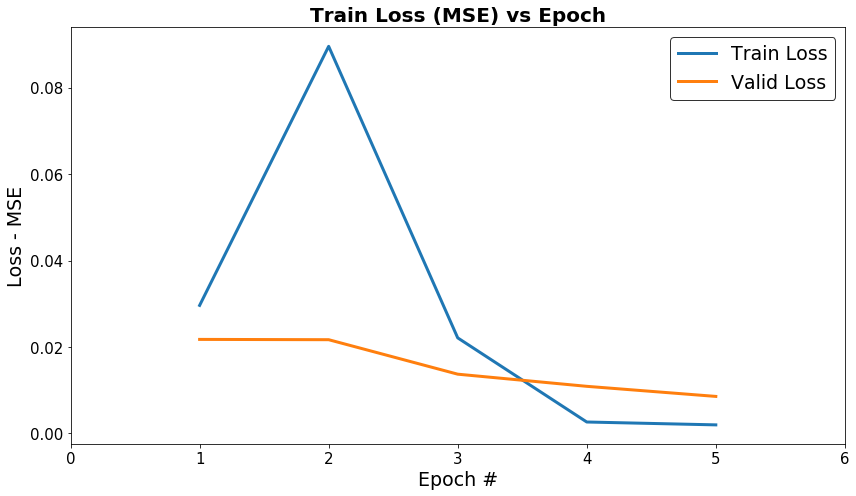

In [33]:
# plot history
figsize = (12, 7)
titlefontsize = 20
xtickfontsize = 15
ytickfontsize = 15
labelfontsize = 19
legendfontsize = 19
linewidth = 3
fig = plt.figure(figsize=figsize)
ax = fig.subplots(1, 1)
ax.plot(np.arange(1, n_epochs+1), history.history['loss'],
        "-",
        linewidth=linewidth,
        label='Train Loss')
ax.plot(np.arange(1, n_epochs+1), history.history['val_loss'],
        "-",
        linewidth=linewidth,
        label='Valid Loss')
ax.set_xlabel("Epoch #", fontsize=labelfontsize)
ax.set_ylabel("Loss - " + loss.upper(), fontsize=labelfontsize)
ax.tick_params(
    axis='x',          
    which='both',      
    labelsize=xtickfontsize)
ax.tick_params(
    axis='y',    
    labelsize=ytickfontsize)
ax.set_title("Train Loss " +  f"({loss})".upper() + " vs Epoch",
        fontsize=titlefontsize,
        fontweight="bold"
    )
ax.legend(loc="upper right",
          fontsize=legendfontsize,
          framealpha=0.8,
          fancybox=True,
          frameon=True,
          shadow=False,
          edgecolor="k")
ax.set_xlim([0, n_epochs+1])
plt.tight_layout()
fname = f"loss-plot-valid.png"
# fig.savefig(os.path.join(ROOT_DIR, "reports", "figures", fname), transparent=False, dpi=dpi)
plt.show()

In [34]:
# make a prediction
yhat_valid = model.predict(x_valid)
y_valid.shape

(53, 6)

In [37]:
# invert normalization/scaling for prediction on valid set
x_valid_ = x_valid.reshape((n_valid, n_lags*n_variables))
y_valid_ = y_valid.reshape((n_valid, n_sequences))
xy_valid_ = np.concatenate((x_valid_, y_valid_), axis=1)
xy_valid_.shape

(53, 102)

In [35]:
xyhat_valid = x_valid_[:, -n_variables:].copy()
xyhat_valid.shape

(53, 16)

In [19]:
xyhat_valid[:,[index_target]] = yhat_valid
xyhat_valid = scaler.inverse_transform(xyhat_valid)

ValueError: shape mismatch: value array of shape (53,6) could not be broadcast to indexing result of shape (1,53)

In [18]:
# invert normalization/scaling for input valid set
x_valid_ = x_valid.reshape((n_valid, n_lags*n_variables))
xy_valid = x_valid_[:, -n_variables:].copy()
xy_valid[:,[index_target]] = y_valid
xy_valid = scaler.inverse_transform(xy_valid)

ValueError: shape mismatch: value array of shape (53,6) could not be broadcast to indexing result of shape (1,53)